# 02 Camera and ray - Numpy broadcasting

* 기존 예제에서 for loop을 제거하고 Numpy의 broadcasting을 이용하여 가속하는 예제입니다.
* GPU를 사용하는 PyTorch 등의 연산으로 쉽게 치환할수 있고 더욱 빨라집니다.

In [1]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt

## Broadcasting
* 크기가 다르지만 호환 가능한 shape을 가진 두 np.array간의 연산을 하는 방식입니다. [numpy broadcasting 설명](https://numpy.org/doc/stable/user/basics.broadcasting.html)
  * 행렬 간의 곱하기 연산(np.matmul, np.dot)과는 다릅니다.
* 사칙연산들이 broadcasting을 지원합니다.
* Python 대신에 C에서 for loop 연산을 수행합니다.
* Shape이 다른 경우 마지막 dimension 부터 맞추게 됩니다. 마지막 dimension 부터 크기가 서로 같거나 하나가 1 이어야 합니다. dimension에서 없는 부분은 1이 됩니다.

### Broadcasting의 예제들
```
Image  (3d array): 256 x 256 x 3
Scale  (1d array):             3
Result (3d array): 256 x 256 x 3

A      (4d array):  8 x 1 x 6 x 1
B      (3d array):      7 x 1 x 5
Result (4d array):  8 x 7 x 6 x 5
```
* 아래 그림은 3채널 이미지와 크기가 3인 벡터 간의 곱하기 연산을 나타낸 그림입니다.

<img src="./images/broadcasting.png" width="700px" height="200px" title="broadcasting"/>


### Broadcasting을 이용한 합수들

* normalize 함수의 입력은 임의 크기의 np.array입니다. 입력이 vec의 크기를 (10 x 15 x 3)이라고 하겠습니다.
  * LA.norm은 입력 np.array의 norm(default는 L2 norm)을 계산하는 함수입니다.
    * https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html
    * np.array의 전체에 대한 norm 대신 마지막 axis를 따라 norm을 계산할 수 있도록 axis는 -1을 입력으로 하였습니다.
      * (10 x 15 x 3) -> (10 x 15)
    * broadcasting을 위해 마지막 axis를 남겨두기 위해 keepdims는 True로 하였습니다.
      * (10 x 15 x 3) -> (10 x 15 x 1)
  * 0으로 나누는 경우를 없애기 위해 epsilon을 더합니다.
    * (10 x 15 x 1) + (1) -> (10 x 15 x 1)
  * 입력 vec을 계산된 norm으로 나눠 줍니다.
    * (10 x 15 x 3) / (10 x 15 x 1) -> (10 x 15 x 3)
* blend는 기존 함수와 차이점은 없지만 pixel 하나가 아닌 이미지 크기의 입력에 대응하는 것을 나타내기 위해 변수의 이름을 변경하였습니다.
  * color1 (3), color2 (3), t_map (height x width x 1)  

In [2]:
def normalize(vec: np.array, eps: float = 1e-6):
    return vec / (LA.norm(vec, axis=-1, keepdims=True) + eps)


def blend(color1: np.array, color2: np.array, t_map: float):
    return (1.0 - t_map) * color1 + t_map * color2

* Ray 클래스도 기존 구현과 다르지 않지만 여러 입력에 대응하는 것을 나타내기 위해 변수의 이름을 변경하였습니다.
  * origin (3), direction_map (h, w, 3), t_map (h, w, 1)

In [3]:
class Ray:
    def __init__(self, origin: np.array, direction_map: np.array) -> None:
        self.origin = origin
        self.direction_map = normalize(direction_map)

    def at(self, t_map: np.array) -> np.array:
        return self.origin + t_map * self.direction_map

* ray_color 함수는 ray.direction_map의 shape이 (h x w x 3)인 것을 고려하여 마지막 dimension의 2번째 값들을 가져오도록 수정했습니다.

In [4]:
def ray_color(ray: Ray) -> np.array:
    t_map = 0.5 * (ray.direction_map[..., 1:2] + 1.0)
    color1 = np.array([1.0, 1.0, 1.0])
    color2 = np.array([0.5, 0.7, 1.0])
    return blend(color1=color1, color2=color2, t_map=t_map)

In [5]:
# image
aspect_ratio = 16.0 / 9.0
image_width = 320
image_height = int(image_width / aspect_ratio)

In [6]:
# camera
viewport_height = 2.0
viewport_width = aspect_ratio * viewport_height
focal_length = 1.0

camera_origin = np.array([0.0, 0.0, 0.0])
horizontal_vec = np.array([viewport_width, 0.0, 0.0])
vertical_vec = np.array([0.0, viewport_height, 0.0])
far_vec = np.array([0.0, 0.0, focal_length])
lower_left_corner = camera_origin - horizontal_vec / 2.0 - vertical_vec / 2.0 - far_vec

* 이미지의 각 픽셀들에 대한 uv coordiante와 color를 계산하던 for loop을 없애고 한번에 계산하도록 수정했습니다.
  * u_map과 v_map의 shape는 (image_height x image_width x 1)입니다.
    * np.newaxis(또는 none)으로 새로운 dimension을 추가합니다.
    * ...은 이전 또는 이후의 모든 dimension을 의미합니다.
* direction_map의 입력은 broadcasting을 활용해 계산합니다.
  * ((3) + (h x w x 1) * (3) + (h x w x 1) * (3)) - (3) -> (h x w x 3)

In [7]:
%%time

us = np.linspace(start=0.0, stop=1.0, num=image_width)
vs = np.linspace(start=0.0, stop=1.0, num=image_height)
u_map, v_map = np.meshgrid(us, vs, indexing="xy")
# u_map = np.expand_dims(u_map, axis=-1)
# v_map = np.expand_dims(v_map, axis=-1)
# 위의 두 줄은 아래의 두줄과 동일한 결과를 냅니다.
u_map = u_map[..., np.newaxis]
v_map = v_map[..., np.newaxis]

ray = Ray(origin=camera_origin,
          direction_map=(lower_left_corner + u_map*horizontal_vec + v_map*vertical_vec) - camera_origin)

image = ray_color(ray=ray)

CPU times: total: 15.6 ms
Wall time: 8 ms


이전의 for문을 사용한 결과와 동일하다면 제대로 구현된 것입니다.

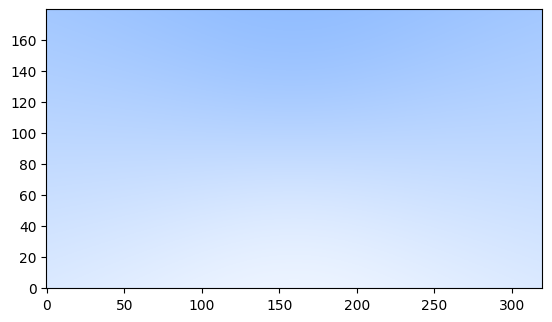

In [8]:
plt.imshow(image, origin="lower")
plt.show()